<a href="https://colab.research.google.com/github/baraabouzaiene/food-cv-app/blob/main/foodCV_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ranitsarkar01/the-food-101-data-set")

print("Path to dataset files:", path)

100%|██████████| 4.66G/4.66G [00:45<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ranitsarkar01/the-food-101-data-set/versions/1


In [ ]:
import torch
import torchvision
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
from torchvision.datasets import Food101


## load the pre-trained VGG16 model


In [ ]:
vgg16 = models.vgg16(pretrained=True)
# I added this line for the Fine-tuning
vgg16.classifier[6] = torch.nn.Linear(4096, 101)

# set the model to evaluation mode
vgg16.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 172MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## preprocessing the input images


In [ ]:
# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet stats
        std=[0.229, 0.224, 0.225]
    )
])

# Load and preprocess the image
train_dataset = Food101(root='./data', split='train', transform=transform, download=True)
test_dataset = Food101(root='./data', split='test', transform=transform, download=True)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


100%|██████████| 5.00G/5.00G [03:45<00:00, 22.1MB/s]


## finetuning

In [ ]:
for param in vgg16.features.parameters():
    param.requires_grad = False  # freezes the convolution layers


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

In [ ]:
# training loop with 1 epoch
for epoch in range(1):
    vgg16.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) #moves batch to GPU if available
        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 4.1656


## inference


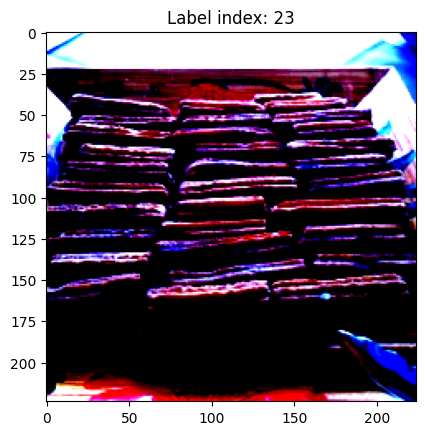

In [ ]:
import matplotlib.pyplot as plt

# the test picture
image, label = test_dataset[0]

# Visualize it
plt.imshow(image.permute(1, 2, 0))  # change from (C,H,W) → (H,W,C)
plt.title(f"Label index: {label}")
plt.show()

In [ ]:
input_tensor=image.unsqueeze(0) # add batch dimention
input_tensor = input_tensor.to(device) # Move the input tensor to the device

with torch.no_grad():
    output = vgg16(input_tensor)
    predicted_class = torch.argmax(output[0])
print(f"Predicted class index: {predicted_class.item()}")

Predicted class index: 16


In [ ]:
#  the class name from the dataset
predicted_class_name = test_dataset.classes[predicted_class.item()]

print(f"predicted class name: {predicted_class_name}")

predicted class name: cheese_plate


## saving the model

In [ ]:
torch.save(vgg16.state_dict(), "vgg16_food101.pth")


## loading the model


In [ ]:
vgg16.load_state_dict(torch.load("vgg16_food101.pth"))


<All keys matched successfully>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi


Sat Oct 11 08:35:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             30W /   70W |    4996MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Save model to Google Drive (so it persists!)
from google.colab import drive
drive.mount('/content/drive')

import torch

# Save to Drive with full path
save_path = '/content/drive/MyDrive/vgg16_food101.pth'
torch.save(vgg16.state_dict(), save_path)

print(f"✅ Model saved to Google Drive: {save_path}")

# Verify
import os
if os.path.exists(save_path):
    size = os.path.getsize(save_path) / (1024 * 1024)
    print(f"✅ File exists! Size: {size:.2f} MB")
    print(f"\n📍 Full path: {save_path}")
else:
    print("❌ Save failed!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to Google Drive: /content/drive/MyDrive/vgg16_food101.pth
✅ File exists! Size: 513.75 MB

📍 Full path: /content/drive/MyDrive/vgg16_food101.pth
